LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [15]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [16]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [17]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = ["SPY", "IWM"]
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [18]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [19]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_IWM.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameter `factor_num` is required only to properly format the output by showing only the stocks but not the factors.

In [20]:
def EfficientFrontier(N, m, G, deltas, factor_num):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
    
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, s)))

        # Conic constraint for the portfolio variance
        if isinstance(G, tuple):
            G_factor = G[0]
            g_specific = G[1]
            
            factor_risk = Expr.mul(G_factor.T, x) 
            specific_risk = Expr.mulElm(g_specific, x)
            total_risk = Expr.vstack(factor_risk, specific_risk)
            
            M.constraint('risk', Expr.vstack(s, total_risk), Domain.inQCone())
        else:
            M.constraint('risk', Expr.vstack(s, Expr.mul(G.T, x)), Domain.inQCone())
    
        # Create DataFrame to store the results. Last security names (the factors) are removed.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns[:-factor_num].tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = s.level()[0]
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

## Define the factor model

Here we define a function that computes the factor model
$$
R_t = \alpha + \beta R_{F,t} + \varepsilon_t.
$$
It can handle any number of factors, and returns estimates $\EBeta$, $\ECov_F$, and $\ECov_\theta$. The factors are assumed to be at the last coordinates of the data. 

The input of the function is the expected return and covariance of yearly logarithmic returns. The reason is that it is easier to generate logarithmic return scenarios from normal distribution instead of generating linear return scenarios from lognormal distribution.  

In [21]:
def factor_model(m_log, S_log, factor_num):
    """
    It is assumed that the last factor_num coordinates correspond to the factors.
    """
    if factor_num < 1: 
        raise Exception("Does not make sense to compute a factor model without factors!")
    
    # Generate logarithmic return scenarios
    scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, 100000)
    
    # Convert logarithmic return scenarios to linear return scenarios 
    scenarios_lin = np.exp(scenarios_log) - 1
    
    # Do linear regression 
    params = []
    resid = []
    X = scenarios_lin[:, -factor_num:]
    X = sm.add_constant(X, prepend=False)
    
    for k in range(N):
        y = scenarios_lin[:, k]
        model = sm.OLS(y, X, hasconst=True).fit()
        resid.append(model.resid)
        params.append(model.params)
    resid = np.array(resid)
    params = np.array(params)
    
    # Get parameter estimates
    a = params[:, 1]
    B = params[:, 0:factor_num]
    S_F = np.atleast_2d(np.cov(X[:, 0:factor_num].T))
    S_theta = np.cov(resid)
    diag_S_theta = np.diag(S_theta)
    
    return a, B, S_F, diag_S_theta 

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [22]:
# Number of factors
fnum = len(list_factors)

# Number of securities (We subtract fnum to account for factors at the end of the price data)
N = df_prices.shape[1] - fnum

# Get optimization parameters
m_orig, S_orig = compute_inputs(df_prices, security_num=N)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [23]:
G_orig = np.linalg.cholesky(S_orig)  

Now we compute the same using the factor model. First we compute logarithmic return statistics and use them to compute the factor exposures and covariances. 

In [24]:
m_log, S_log = compute_inputs(df_prices, return_log=True)
_, B, S_F, diag_S_theta = factor_model(m_log, S_log, fnum)

We arrive at the $G$ matrix defined by the factor model.

In [25]:
F = np.linalg.cholesky(S_F)
G_factor = B @ F 
g_specific = np.sqrt(diag_S_theta)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{1.5}$. We compute the efficient frontier this way both with and without using factor model. 

In [26]:
# Compute efficient frontier with and without factor model
deltas = np.logspace(start=-1, stop=1.5, num=20)[::-1]
df_result_orig = EfficientFrontier(N, m_orig, G_orig, deltas, fnum)
df_result_factor = EfficientFrontier(N, m_orig, (G_factor, g_specific), deltas, fnum)

# Set small negatives to zero to make plotting work
mask = df_result_orig < 0
mask.iloc[:, :-8] = False
df_result_orig[mask] = 0

# Set small negatives to zero to make plotting work
mask = df_result_factor < 0
mask.iloc[:, :-8] = False
df_result_factor[mask] = 0

## Visualize the results

Plot the efficient frontier for both cases.

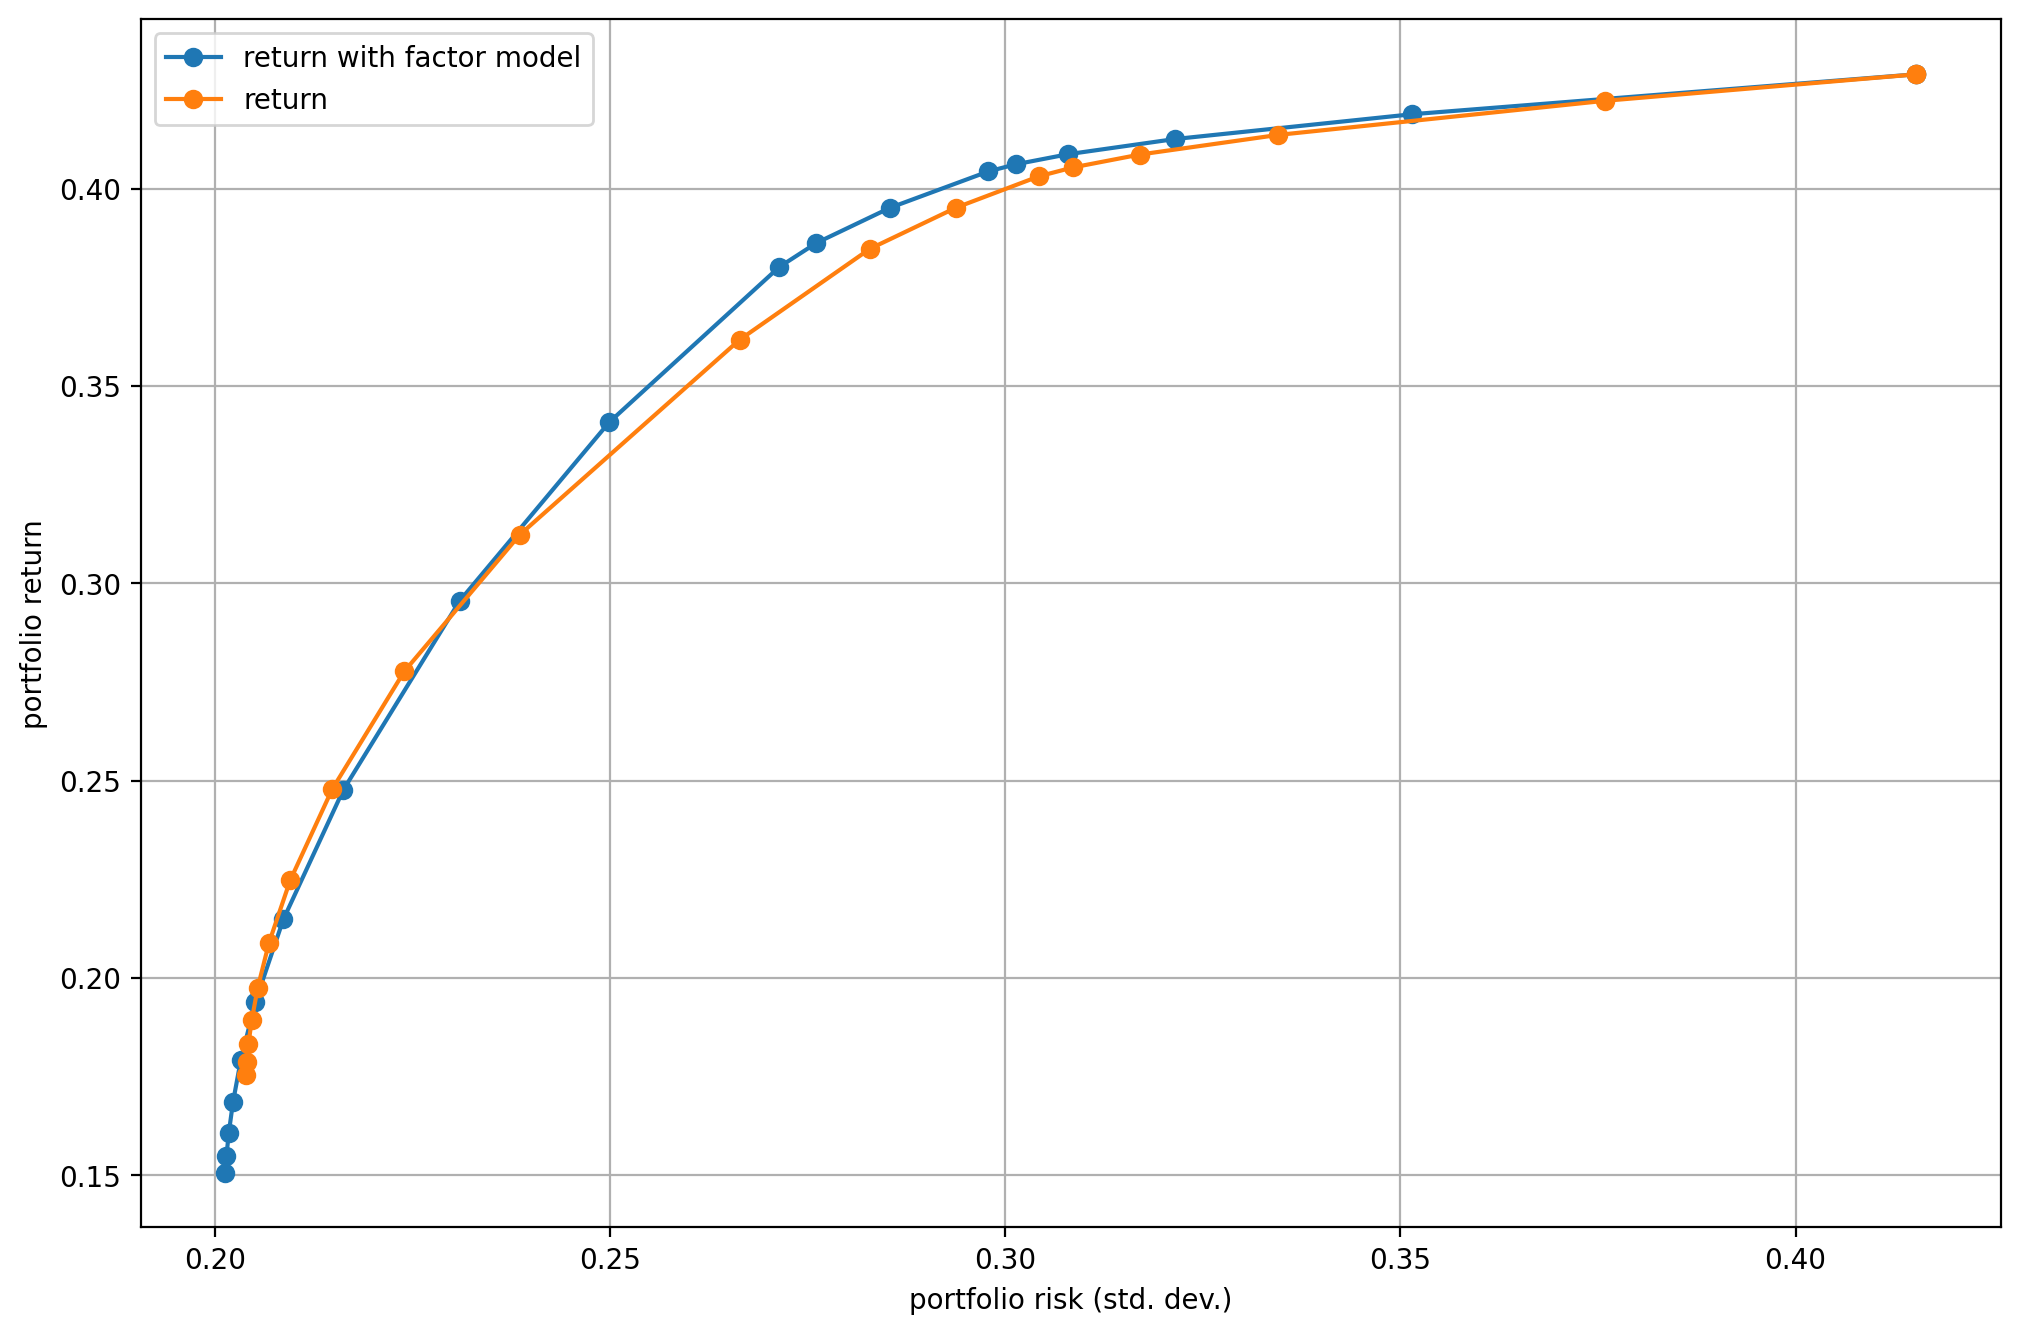

In [27]:
ax = df_result_factor.plot(x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
df_result_orig.plot(ax=ax, x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)   
ax.legend(["return with factor model", "return"]);

Plot the portfolio composition for both cases.

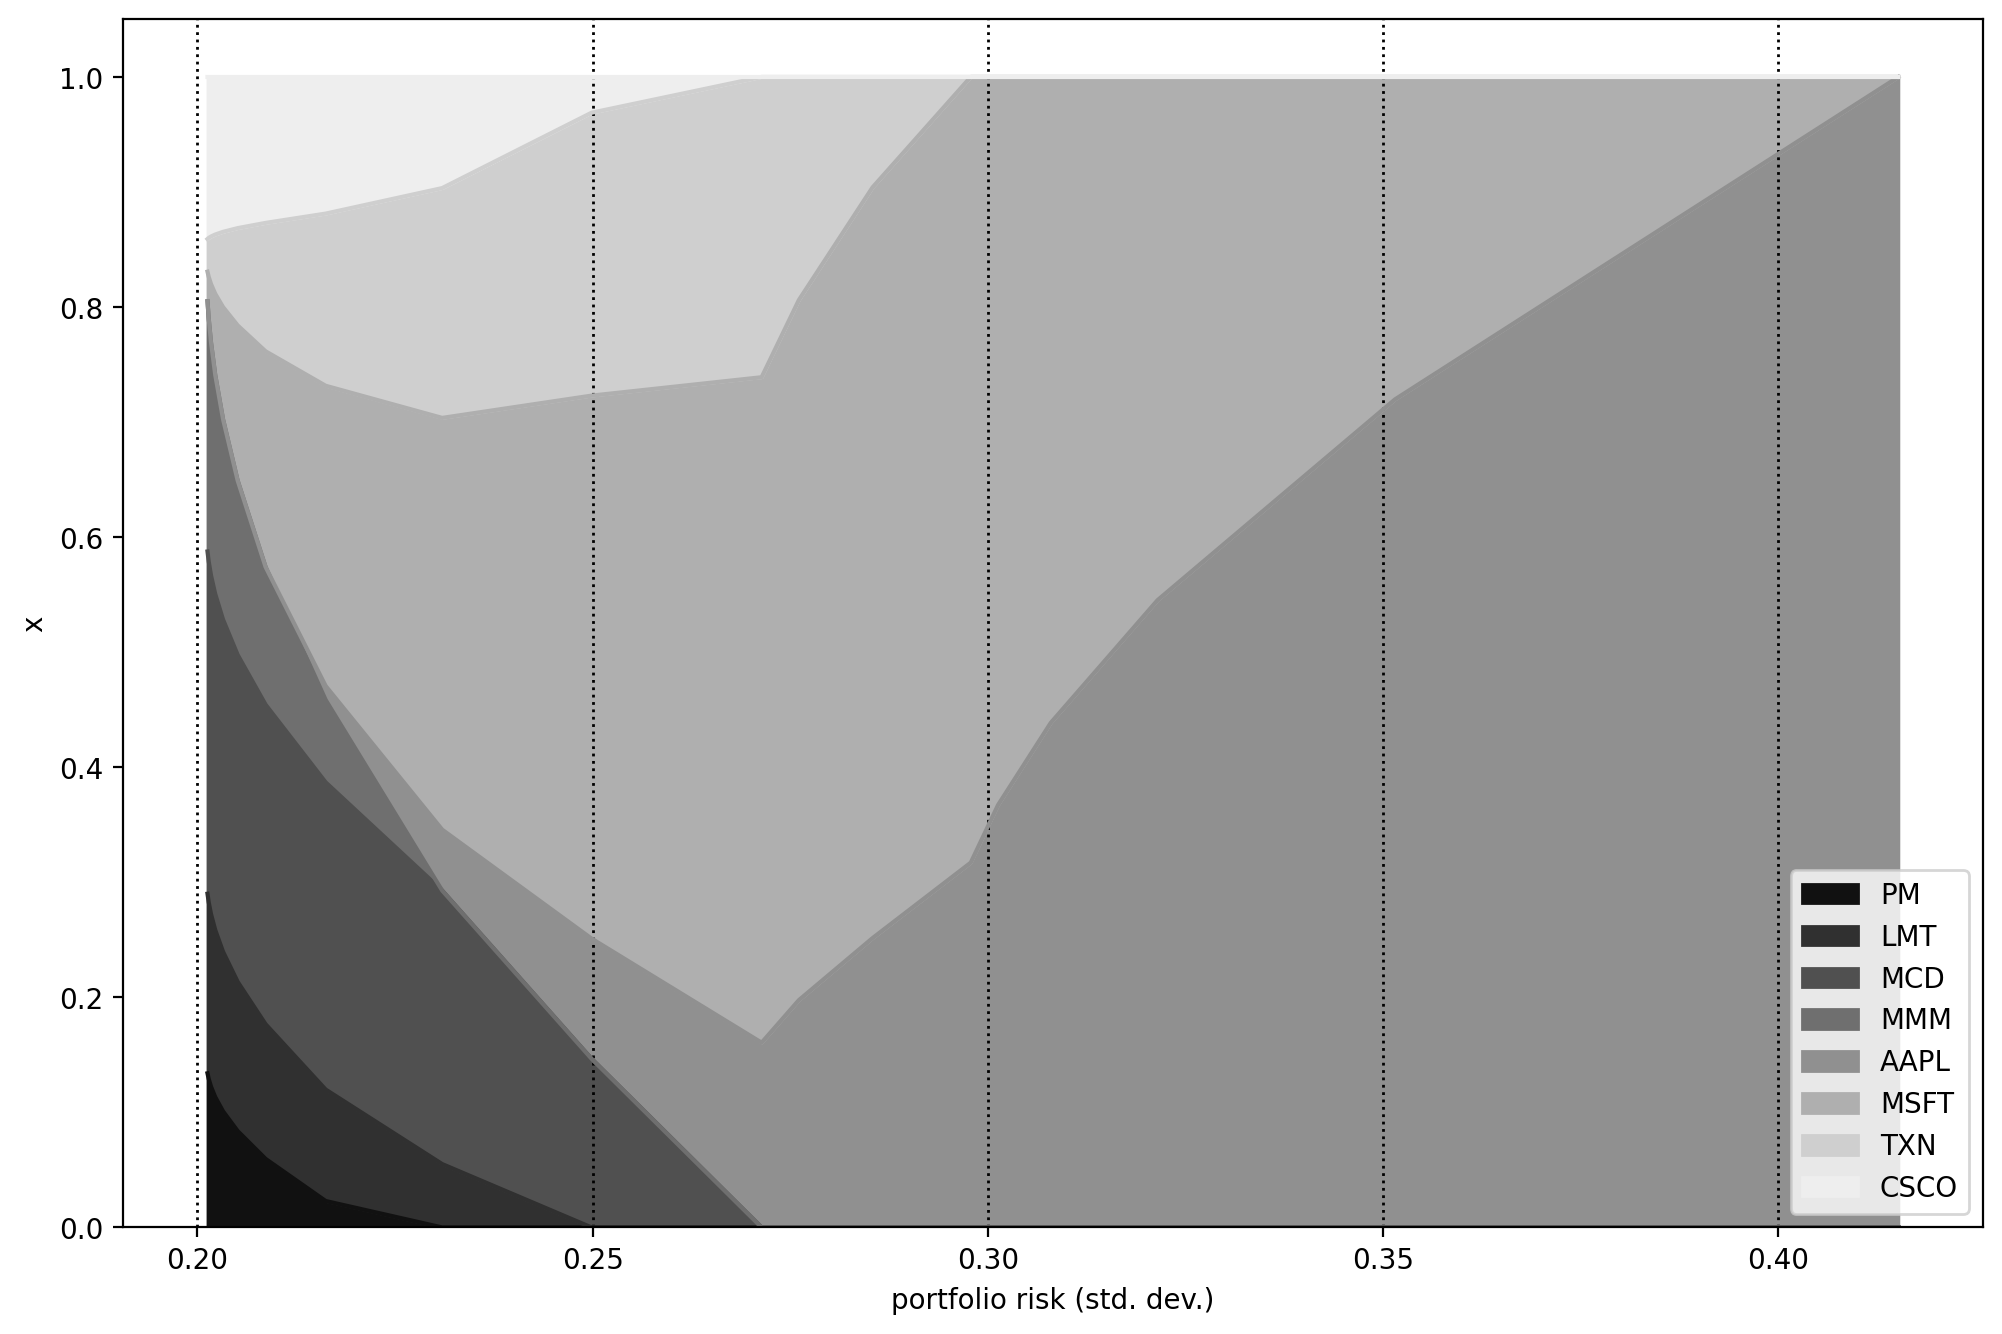

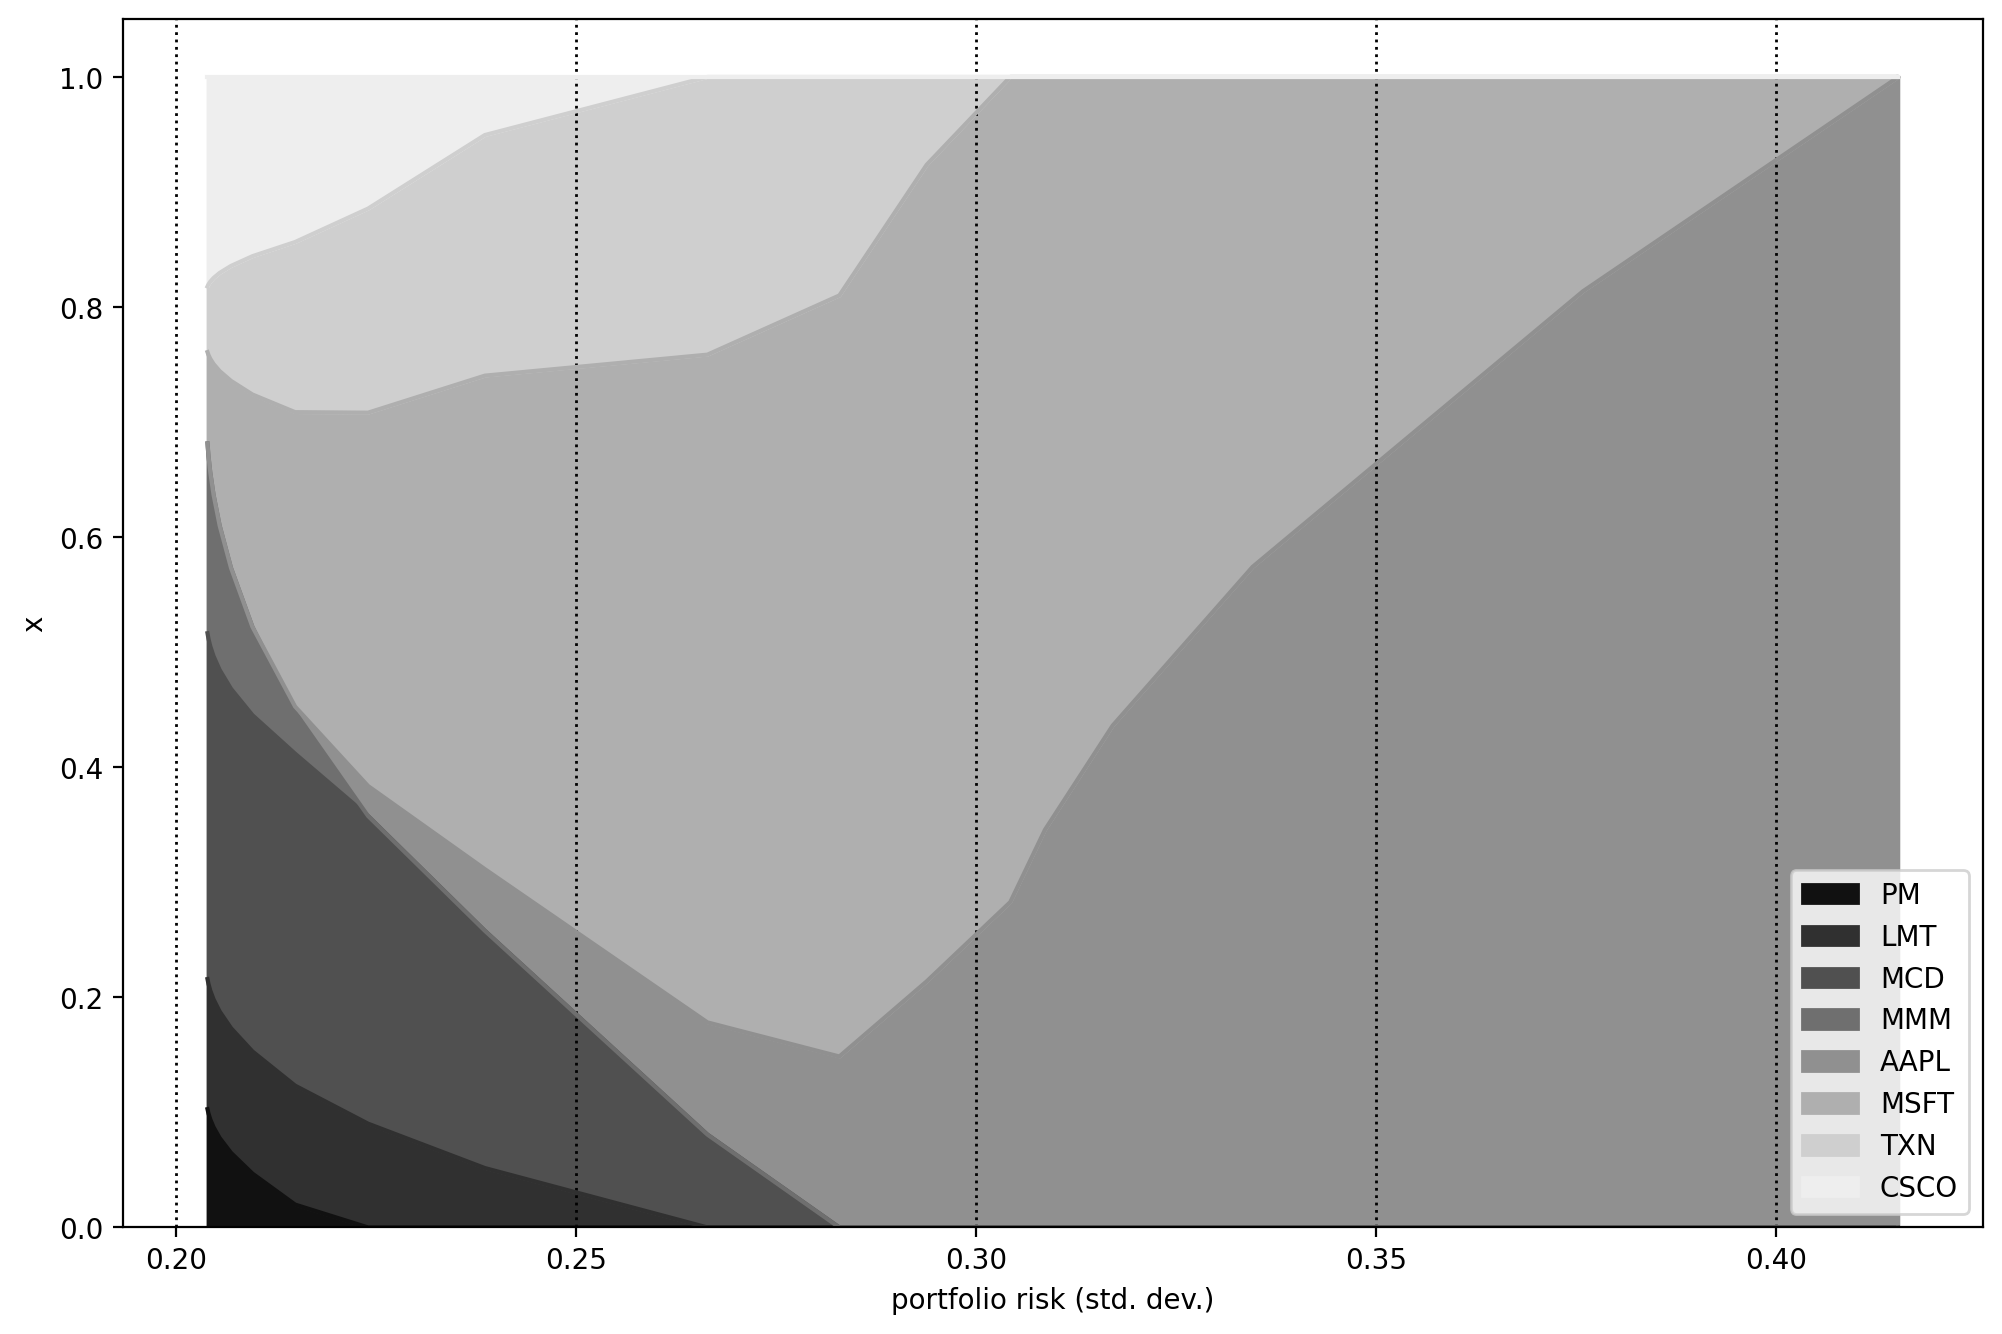

In [28]:
# Plot portfolio composition
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax1 = df_result_factor.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x")
ax1.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)
ax2 = df_result_orig.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x") 
ax2.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)